### Онлайн-гипермаркет «Утконос» – это сервис доставки продуктов нового поколения, совмещающий традиционные и современные технологии розничной торговли. 
Утконос был создан в 2000 году и на данный момент является одним из лидеров e-grocery на российском рынке. Ассортимент интернет-магазина насчитывает более 400 товарных категорий.

Поэтому наша задача – построить поведенческую модель покупателей для прогнозирования вероятности и ожидаемого времени отмены заказа. Такая модель позволит компании оптимизировать бизнес-процесс.

Подключаем необходимые библиотеки

In [95]:
import pandas as pd
import numpy as np
import datetime
import glob
import lightgbm as lgb
#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

Загружаем данные из CSV файла в пандасовский датафрейм

In [96]:
data = pd.read_csv('train.csv', encoding='cp1251', low_memory=False)

Ознакамливаемся с данными, открываем первые 10:

In [97]:
data.head(10)

,Interval,Date,OrderDate,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,DeliveryType,prepay,count_edit
0,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328810.0,61.0,NaN,0,1.0,Обычная доставка,0,1
1,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3281258.0,30.0,NaN,0,2.0,Обычная доставка,0,1
2,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3210734.0,10.0,NaN,0,1.0,Обычная доставка,0,1
3,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328848.0,61.0,NaN,0,2.0,Обычная доставка,0,1
4,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3347801.0,17.0,NaN,0,10.0,Обычная доставка,0,1
5,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3044324.0,11.0,NaN,0,6.0,Обычная доставка,0,1
6,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3347802.0,17.0,NaN,0,7.0,Обычная доставка,0,1
7,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3076533.0,63.0,NaN,0,4.0,Обычная доставка,0,1
8,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3155553.0,23.0,NaN,0,1.0,Обычная доставка,0,1
9,19-21.,05/10/2018,05/10/2018,93696397,2,90102092000,3344245.0,5.0,NaN,0,1.0,Доставка День в День,0,1


Удаляем ненужные данные: в нашем случае это ID клиента, потому что эта информация не влияет на нахождение закономерности отказа от заказа

In [98]:
data = data.drop(['ClientID'], axis=1)

Приводим временной интервал доставки на более удобный формат для дальнейшей обработки. Удаляем ненужную переменную data['Interval']

In [99]:
tmp = data['Interval'].str.split('-')
data['int0']=tmp.apply(lambda x: int(x[0]))
data['int1']=tmp.apply(lambda x: int(x[1][:-1]))
del data['Interval']

Определяем до скольких дней длился заказ до доставки или до момента отказа

In [100]:
orderDate = data.OrderDate.apply (lambda x: datetime.datetime.strptime (x, '%d/%m/%Y'))
date = data.Date.apply (lambda x: datetime.datetime.strptime (x, '%d/%m/%Y'))
data['delta_day'] = (date-orderDate).dt.days.astype(int).values

In [101]:
data['delta_day'].head()

0    1
1    1
2    1
3    1
4    2
Name: delta_day, dtype: int32

Выделяем день недели, когда был произведен заказ (переменная order_weekday), доставлен или отменен (переменная weekday)

In [102]:
order_weekday = data['OrderDate'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y').weekday())
weekday = data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y').weekday())

In [103]:
data['order_weekday'] = order_weekday
data['weekday'] = weekday

Удаляем даты, так как точная дата заказа не влияет на закономерность

In [104]:
del data['Date']
del data['OrderDate']

Находим середину интервала, чтобы определить в какое время суток была произведена доставка

In [105]:
interval_low = data['int0']
interval_high = data['int1']
#interval_time = interval_high - interval_low
interval_avg = (interval_high + interval_low) / 2

In [106]:
morning = list(range(6, 12))
day = list(range(12, 18))
evening = list(range(18, 24))
night = [24] + list(range(1, 6))

In [107]:
morning = interval_avg.isin(morning)
day = interval_avg.isin(day)
evening = interval_avg.isin(evening)
night = interval_avg.isin(night)

In [108]:
#data['interval_time'] = interval_time
data['interval_low'] = interval_low
data['interval_high'] = interval_high
data['interval_avg'] = interval_avg
data['morning'] = morning.apply(lambda x: 1 if x else 0)
data['day'] = day.apply(lambda x: 1 if x else 0)
data['evening'] = evening.apply(lambda x: 1 if x else 0)
data['night'] = night.apply(lambda x: 1 if x else 0)

Выявляем, в какой день недели был произведен заказ

In [109]:
data['is_order_weekend'] = data['order_weekday'].apply(lambda x: 1 if x in [5,6] else 0)
data['is_weekend'] = data['weekday'].apply(lambda x: 1 if x in [5,6] else 0)

Уменьшаем количество изменений заказа, так как 1 означает только первоначальный ввод без изменений

In [110]:
data['count_edit'] -= 1

Производим замену типа доставки на более удобный для обработки вид. 
Обычную доставку будет обозначать 0, а доставку день в день - 1

In [111]:
data['DeliveryType'] = data['DeliveryType'].map({'Обычная доставка': 0, 'Доставка День в День': 1})

Смотрим из каких данных состоит датафрейм

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9023184 entries, 0 to 9023183
Data columns (total 24 columns):
ChannelID           int64
OrderID             int64
MaterialID          float64
GroupID             float64
Cluster             object
CancelFlag          int64
OrderCnt            float64
DeliveryType        int64
prepay              int64
count_edit          int64
int0                int64
int1                int64
delta_day           int32
order_weekday       int64
weekday             int64
interval_low        int64
interval_high       int64
interval_avg        float64
morning             int64
day                 int64
evening             int64
night               int64
is_order_weekend    int64
is_weekend          int64
dtypes: float64(4), int32(1), int64(18), object(1)
memory usage: 1.6+ GB


Находим дисперсию данных, чтобы выдвинуть гипотезу о том, как данные о типе доставки, длительности ожидания заказа, предоплаты, времени суток и количестве редактирований влияют на отмену заказа.

In [113]:
#Дисперсия 
data[['CancelFlag', 'DeliveryType', 'delta_day', 
           'prepay', 'morning', 'day', 'evening', 'night', 'count_edit', 'is_order_weekend', 'is_weekend']].groupby('CancelFlag').var()

,DeliveryType,delta_day,prepay,morning,day,evening,night,count_edit,is_order_weekend,is_weekend
CancelFlag,,,,,,,,,,
0,0.022959,0.233153,0.162488,0.234013,0.230098,0.183114,0.003225,17.152443,0.195696,0.210585
1,0.016801,0.452698,0.063171,0.232487,0.229998,0.176597,0.006069,24.137897,0.192930,0.208717


После нахождения дисперсии можем заметить, что тип доставки, длительность времени ожидания, предоплата, количество редактирований значительно влияют на отмену заказа. А время суток, и выходные дни влияют довольно НЕзначительно

Чтобы выявить какой день недели больше всего влияет на отмену заказа и проще было построить диаграмму, разделяем данные по дням недели

In [114]:
monday = data.order_weekday.apply(lambda x: 1 if x==0 else 0)
tuesday = data.order_weekday.apply(lambda x: 1 if x==1 else 0)
wednesday = data.order_weekday.apply(lambda x: 1 if x==2 else 0)
thursday = data.order_weekday.apply(lambda x: 1 if x==3 else 0)
friday = data.order_weekday.apply(lambda x: 1 if x==4 else 0)
saturday = data.order_weekday.apply(lambda x: 1 if x==5 else 0)
sunday = data.order_weekday.apply(lambda x: 1 if x==6 else 0)

data['monday'] = monday
data['tuesday'] = tuesday
data['wednesday'] = wednesday
data['thursday'] = thursday
data['friday'] = friday
data['saturday'] = saturday
data['sunday'] = sunday


In [115]:
data.columns

Index(['ChannelID', 'OrderID', 'MaterialID', 'GroupID', 'Cluster',
       'CancelFlag', 'OrderCnt', 'DeliveryType', 'prepay', 'count_edit',
       'int0', 'int1', 'delta_day', 'order_weekday', 'weekday', 'interval_low',
       'interval_high', 'interval_avg', 'morning', 'day', 'evening', 'night',
       'is_order_weekend', 'is_weekend', 'monday', 'tuesday', 'wednesday',
       'thursday', 'friday', 'saturday', 'sunday'],
      dtype='object')

Находим отношение отмененных на общее количество заказов.

In [116]:
cancel_data = data[['CancelFlag', 'monday', 'tuesday', 'wednesday', 'thursday',
           'friday', 'saturday', 'sunday']].groupby('CancelFlag').sum()
print(cancel_data)
size1 = cancel_data.values[1]
size2 = cancel_data.values[0]
proportion=size1/(size1+size2)

print(proportion)

             monday  tuesday  wednesday  thursday   friday  saturday   sunday
CancelFlag                                                                   
0           1128122  1124982    1265072   1406148  1320428   1212433  1061889
1             72052    67202      74459     83649    75122     67769    63857
[0.06003463 0.05636882 0.05558587 0.05614792 0.05382967 0.05293618
 0.05672416]


Импортируем библиотеку matplotlib и строим диаграмму по найденному отношению

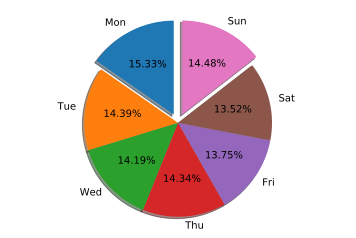

In [117]:
import matplotlib.pyplot as plt

labels = 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'
explode = (0.1, 0, 0, 0, 0, 0, 0.1) 
fig1, ax1 = plt.subplots()

ax1.pie(proportion*100, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

Находим отказы при предоплате:

CancelFlag
0    8519074
1     504110
Name: prepay, dtype: int64


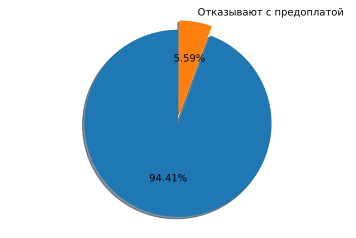

In [118]:
cancel_data = data[['CancelFlag', 'prepay']].groupby('CancelFlag').count()['prepay']
print(cancel_data)

labels = '', 'Отказывают с предоплатой'
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(cancel_data, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

Сохраняем предобработанные данные:

In [119]:
data.to_csv('data_preprocessed.csv', index=False)

In [120]:
data = pd.read_csv('data_preprocessed.csv', encoding='cp1251', low_memory=False)

In [121]:
data.shape

(9023184, 31)

Находим отношение количества отказов на количество всех заказов по определенному количеству дней доставки

In [122]:
cancelled = data[['CancelFlag', 'delta_day']].groupby('delta_day').sum()['CancelFlag']
all_orders = data[['CancelFlag', 'delta_day']].groupby('delta_day').count()['CancelFlag']
#print(canceled/all_orders)
cancelled_proportion = cancelled/all_orders
cancelled_proportion.values

array([1.        , 1.        , 1.        , 1.        , 0.04721937,
       0.04866868, 0.09369369, 0.08410173, 0.17380039, 0.18125293,
       0.32575555, 0.2       , 0.09473684, 0.53846154, 0.125     ,
       0.28571429, 0.4       , 0.35294118, 0.46153846, 0.35294118,
       0.5       , 0.4       , 0.875     , 0.75      , 1.        ,
       0.75      , 0.375     , 1.        , 1.        ])

Импортируем специальные библиотеки для построения графика

In [123]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Строим график по вычисленным данным

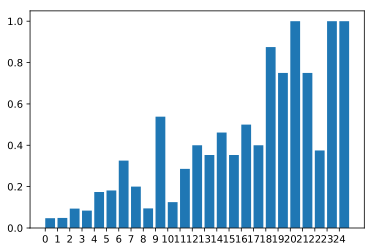

In [124]:
cancelled_proportion_values = cancelled_proportion[cancelled_proportion.index >= 0]

s = cancelled_proportion_values
x = range(len(s))
ax = plt.gca()
ax.bar(x, s, align='edge')
ax.set_xticks(x)
ax.set_xticklabels((cancelled_proportion.index+4))
plt.show()

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

Производим удаление отсутствующих значений, берем медиану по числовому значению и добавляем в пустые строки

In [126]:
data.dropna()
data = data.fillna(data.median(axis=0), axis=0)

In [227]:
X = data[['OrderCnt', 'DeliveryType', 'prepay', 'count_edit',
       'int0', 'int1', 'delta_day', 'order_weekday']]#'MaterialID', 'GroupID',, 'weekday', 'interval_avg', 'morning', 'day', 'evening', 'night',
       #'is_order_weekend', 'is_weekend'

In [228]:
y = data.values[::, 5]
y = y.astype(int)

In [229]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

In [231]:
clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=9,
                             min_samples_leaf = 2,
                             random_state=4)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=4,
            splitter='best')

In [232]:
from sklearn.tree import export_graphviz
import subprocess
export_graphviz(clf, out_file='D:/Data/Utkonos_tree.dot',
rounded = True, proportion = False,
precision = 2, filled = True)
import pydot
(graph, ) = pydot.graph_from_dot_file('D:/Data/Utkonos_tree.dot')
graph.write_png('D:/Data/Utkonos_tree.png')

In [233]:
clf.score(X_train, y_train)

0.9448598148103681

In [234]:
clf.score(X_test,y_test)

0.9446293033390651

Строим решающее дерево с использованием критерия Gini.

In [225]:
clfGN = DecisionTreeClassifier(criterion='gini',
                               max_depth=5,
                               min_samples_leaf = 5,
                               random_state=10)
clfGN.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [209]:
clfGN.score(X_test, y_test)

0.9443079237342609

Импортируем библиотеки 

In [210]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score

In [222]:
def plot_roc_curve(fpr, tpr, n, current_score):
    plt.plot(fpr, tpr, color='green', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with AUC score - %.4f' % current_score)
    plt.legend()
    plt.show()
    plt.close()

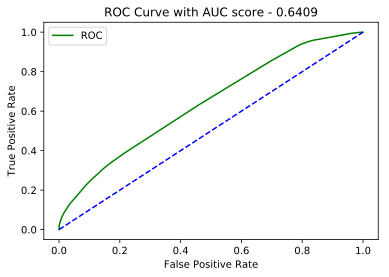

In [224]:
val_score = max(cross_val_score(model, X_test, y_test, cv=10))
probs = model.predict_proba(X_test)

probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)

# вычисление среднеквадратичной ошибки
rmse = np.sqrt(mean_squared_error(y_test, probs))

# вычисление коэффициента детерминизации
r2 = r2_score(y_test, probs)

fpr, tpr, thresholds = roc_curve(y_test, probs)

#используем метод, описанный в предыдущем блоке, который строит и выводит график ROC-кривой
plot_roc_curve(fpr, tpr, "tree/roc/cor_gini", auc)

fileDot = 'resources/tree/model/cor_gini.dot'
filePng = 'resources/tree/model/cor_gini.png'

Находим оптимальную глубину дерева:

In [270]:
max_depth_values = range(2, 30)

In [271]:
scores_data = pd.DataFrame()

In [272]:
for max_depth in max_depth_values:    
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test,y_test)
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 
                                    'train_score': [train_score],
                                    'test_score': test_score})
    scores_data = scores_data.append(temp_score_data)

In [273]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'],
                          var_name = 'set_type', value_name='score')

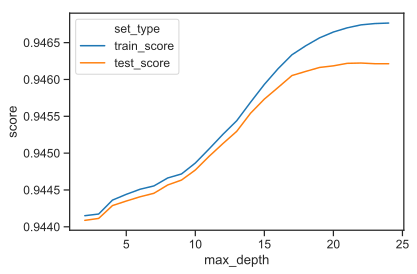

In [274]:
sns.lineplot(x="max_depth", y="score", hue="set_type", data=scores_data_long)

Оптимальная глубина дерева 23

In [205]:
X = data[['OrderCnt', 'DeliveryType', 'prepay', 'count_edit',
       'int0', 'int1', 'delta_day']]

In [206]:
y = data.values[::, 5]
y = y.astype(int)

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Создаём модель леса из сотни деревьев, а также обучаем на тренировочных данных

In [264]:
from sklearn.ensemble import RandomForestClassifier

modelRandForest = RandomForestClassifier(n_estimators=100, 
                               criterion='entropy',
                               bootstrap = True,
                               max_features = 'sqrt')
modelRandForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [265]:
y_pred_proba = modelRandForest.predict_proba(X_test)[::,1]
fprRF, tprRF, _ = metrics.roc_curve(y_test,  y_pred_proba)
roc_RF = metrics.roc_auc_score(y_test, y_pred_proba)

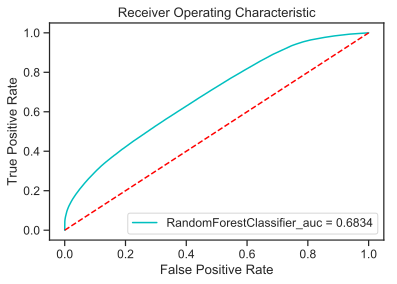

In [266]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.title('Receiver Operating Characteristic')
plt.plot(fprRF, tprRF, 'b', color='c', label = 'RandomForestClassifier_auc = %0.4f' % roc_RF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.grid(False)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()